In [1]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
from pyrocko import moment_tensor as mtm
from importlib import reload

import proba_modules as pm

In [2]:
PATH_VENUS_DATA = os.path.join("./data/")
PATH_VENUS = os.path.join(f"{PATH_VENUS_DATA}wrinkle_ridges")
VENUS_wrinkles = dict(wrinkles=gpd.read_file(f"{PATH_VENUS}/wrinkle_ridges.shp"))

PATH_VENUS_DATA = os.path.join("./data/")
PATH_VENUS = os.path.join(f"{PATH_VENUS_DATA}Venus_data/tectonic_settings_Venus")
VENUS_tectonic = {
    'corona': gpd.read_file(f"{PATH_VENUS}/corona.shp"),
    'rift': gpd.read_file(f"{PATH_VENUS}/rifts.shp"),
    'ridge': gpd.read_file(f"{PATH_VENUS}/ridges.shp"),
}

In [3]:
file_curve = './data/GF_data/GF_Dirac_1Hz_all.csv'
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, dist_min=100., rho0=67., rhob=2.792, cb=304., use_savgol_filter=True, plot=True, scalar_moment=10e6)

TypeError: get_TL_curves() missing 1 required positional argument: 'freq'

In [4]:
def rate_from_slope(mw, slope, intercept):
    return 10**(np.log10(mtm.magnitude_to_moment(mw))*slope+intercept)

def return_number_per_cat_and_setting(pd_slopes, cat_quake, setting):
    slope = pd_slopes.loc[(pd_slopes.type_setting==setting)&(pd_slopes.type_unknown=='slope'), cat_quake].iloc[0]
    intercept = pd_slopes.loc[(pd_slopes.type_setting==setting)&(pd_slopes.type_unknown=='intercept'), cat_quake].iloc[0]
    func = lambda mw: rate_from_slope(mw, slope, intercept)
    return func

def return_number_per_cat_and_setting_wrinkles(pd_slopes, cat_quake, setting):

    popt = pd_slopes.loc[(pd_slopes.type_setting==setting), cat_quake].values
    poly1d = np.poly1d(popt)
    func = lambda mw: 10**poly1d(mw)
    
    return func

file_slopes = './data/Venus_data/distribution_venus_per_mw.csv'
pd_slopes = pm.get_slopes(file_slopes)

file_slopes = './data/wrinkle_ridges/distribution_venus_per_mw_wrinkles.csv'
pd_slopes_wrinkles = pm.get_slopes(file_slopes)

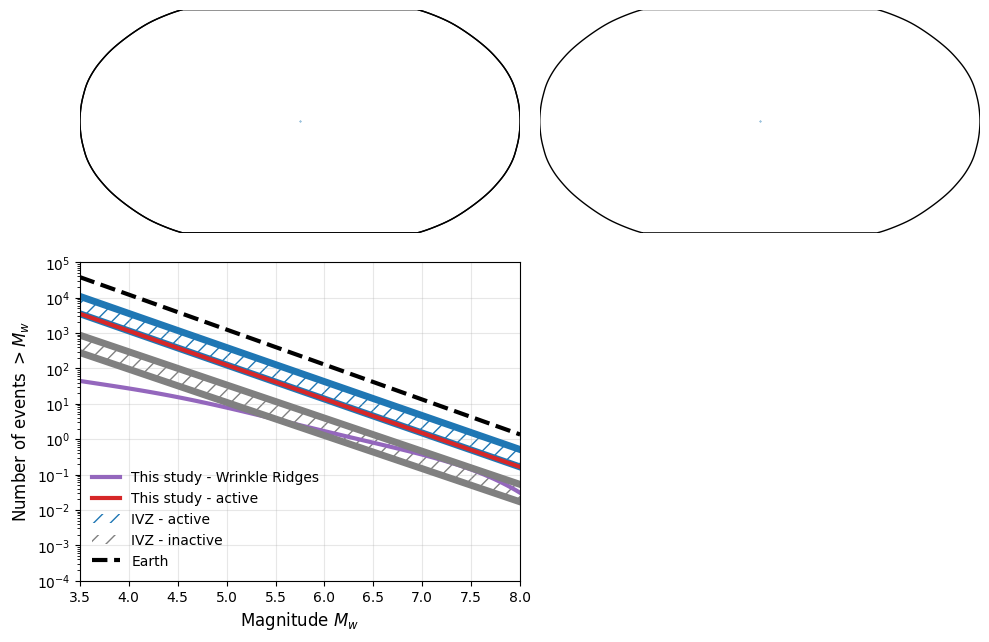

In [11]:
reload(pm)
from obspy.geodetics import kilometers2degrees

fontsize_label = 20.
plot_labels = False

fig = plt.figure(figsize=(10,7))
grid = fig.add_gridspec(2, 2)

ax = fig.add_subplot(grid[0, 0])
m = Basemap(projection='robin', lon_0=0, ax=ax)
#m = Basemap(projection='aeqd', lon_0 = 0, lat_0 = 90., ax=ax)
m.scatter(0., 0., latlon=True, s=0.1)
#m.fillcontinents(color='white', lake_color='white')
m.drawmapboundary(fill_color='white')
pm.plot_regions(m, ax, VENUS_tectonic, use_active_corona=True, plot_lines=True)
if plot_labels:
    ax.text(-0.1, 1., 'a)', fontsize=fontsize_label, ha='right', va='bottom', transform=ax.transAxes)

ax = fig.add_subplot(grid[0, 1])
m = Basemap(projection='robin', lon_0=0, ax=ax)
#m = Basemap(projection='aeqd', lon_0 = 0, lat_0 = 80., ax=ax)
m.scatter(0., 0., latlon=True, s=0.1)
m.drawmapboundary(fill_color='white')
#pm.plot_regions(m, ax, VENUS_wrinkles, use_active_corona=True, plot_lines=True)
if plot_labels:
    ax.text(-0.1, 1., 'b)', fontsize=fontsize_label, ha='right', va='bottom', transform=ax.transAxes)

ax = fig.add_subplot(grid[1, 0])
mw = np.linspace(3.5, 8., 100)
scenarios = ['active_low_min', 'active_low_max', 'inactive_min', 'inactive_max']
colors = {'active_low_min': 'tab:blue', 'active_low_max': 'tab:blue', 'inactive_min': 'grey', 'inactive_max': 'grey'}
selected_scenario = 'active_low_min'

f_rate = return_number_per_cat_and_setting_wrinkles(pd_slopes_wrinkles, 'wrinkle_ridges', 'wrinkle_ridges')
ax.plot(mw, f_rate(mw), color='tab:purple', linewidth=3., label=f'This study - Wrinkle Ridges')
for iscenario, scenario in enumerate(scenarios):
    
    rate = [0] * mw
    for region in pd_slopes.loc[:, ~pd_slopes.columns.str.contains('type_')].columns:
        if 'inactive' in scenario and not region == 'intraplate':
            continue
        f_rate = return_number_per_cat_and_setting(pd_slopes, region, scenario)
        rate += f_rate(mw)
    
    if 'min' in scenario:
        min_vals = rate.copy()
    
    if 'max' in scenario:
        max_vals = rate.copy()

    if (iscenario+1)%2 == 0:
        ax.fill_between(mw, min_vals, max_vals, label=f"IVZ - {' '.join(scenario.split('_')[0:1])}", color=colors[scenario], hatch='//', edgecolor='None',alpha=0.,)

    ax.plot(mw, rate, color=colors[scenario], linewidth=5.)
    if scenario == selected_scenario:
        ax.plot(mw, rate, color='tab:red', linewidth=3., label=f'This study - {" ".join(scenario.split("_")[0:1])}')

slope_earth, intercept_earth = -0.6590366497863146, 14.005110447994516
ax.plot(mw, rate_from_slope(mw, slope_earth, intercept_earth), color='black', linestyle='--', linewidth=3., label='Earth')
ax.grid(alpha=0.3)
ax.set_yscale('log')
ax.legend(frameon=False, loc='lower left', ncol=1)
ax.set_xlabel('Magnitude $M_w$', fontsize=12.)
ax.set_ylabel('Number of events $> M_w$', fontsize=12.)
ax.set_ylim([1e-4, 1e5])
ax.set_xlim([mw.min(), mw.max()])
if plot_labels:
    ax.text(-0.1, 1., 'c)', fontsize=fontsize_label, ha='right', va='bottom', transform=ax.transAxes)

"""
ax = fig.add_subplot(grid[1, 1])
periods = np.logspace(-2, 1)
rho0=67.
rhob=2.792
cb=304.
density_ratio = rhob*cb*np.sqrt(rho0/(rhob))
model_empirical = lambda mw, t, d: density_ratio*(2*np.pi*1e-6)*t*10**(mw-3.3-1.66*np.log10(kilometers2degrees(d)))
dists = np.linspace(1., 18e3, 100)
mags = [4., 5.]
noise_level = 1.
colors = ['brown', 'lightseagreen']
for imag, mag in enumerate(mags):
    label = dict()
    if imag == len(mags)-1:
        label['label'] = 'uncertainty'
    ax.plot(dists, TL_new(dists, mag)/noise_level, label=f'$M_w$ {mag}', linewidth=3, color=colors[imag])
    ax.fill_between(dists, TL_new_qmin(dists, mag)/noise_level, TL_new_qmax(dists, mag)/noise_level, color=colors[imag], alpha=0.15)

    PP, DD = np.meshgrid(periods, dists)
    amps_empirical = model_empirical(mag, PP, DD)
    ax.plot(dists, np.quantile(amps_empirical, axis=1, q=0.5)/noise_level, label=f'$M_w$ {mag} - RG24', linewidth=3., linestyle='--', color=colors[imag])
    ax.fill_between(dists, np.quantile(amps_empirical, axis=1, q=0.25)/noise_level, np.quantile(amps_empirical, axis=1, q=0.75)/noise_level, color=colors[imag], alpha=0.15, **label)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Distance (km)', fontsize=12.)
ax.set_ylabel('Amplitude (Pa)', fontsize=12.)
ax.grid(alpha=0.3)
ax.legend(frameon=False, )
ax.set_xlim([10., dists.max()])
if plot_labels:
    ax.text(-0.1, 1., 'd)', fontsize=fontsize_label, ha='right', va='bottom', transform=ax.transAxes)
"""

fig.tight_layout()
fig.savefig("./figures/Figure_1_transparent_AGU.png", transparent=True)

In [ ]:
np.degrees()

In [132]:
amps_empirical.shape

(100, 50)

In [82]:
fig.savefig('./figures/Figure_1_seismicity.pdf')

Processing region corona


100%|██████████| 548/548 [00:04<00:00, 124.94it/s]


Processing region rift


100%|██████████| 57/57 [00:00<00:00, 77.91it/s] 


Processing region ridge


100%|██████████| 193/193 [00:01<00:00, 144.57it/s]


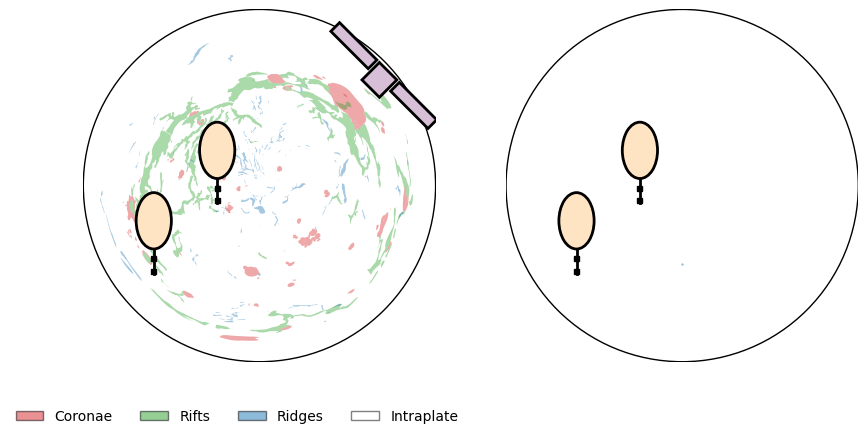

In [128]:
from matplotlib.patches import Ellipse, Rectangle

def add_balloon(ax, x_axis, y_axis, width_balloon, height_balloon, height_tether):

    line_y_top, line_y_bottom = y_axis - height_balloon/2., y_axis - height_balloon/2.-height_tether
    line_x = x_axis

    ax.plot([line_x, line_x], [line_y_top, line_y_bottom], color='k', linewidth=2, transform=ax.transAxes)
    ellipse = Ellipse((x_axis, y_axis), width=width_balloon, height=height_balloon, edgecolor='black', facecolor='bisque', lw=2, transform=ax.transAxes, clip_on=True)
    ax.add_patch(ellipse)

    n_squares = 2
    square_size = 0.2 * (line_y_top - line_y_bottom)
    for i in range(n_squares):
        square_y = line_y_bottom + i * (line_y_top - line_y_bottom) / n_squares
        square = Rectangle((line_x - square_size / 2, square_y), square_size, square_size, edgecolor='black', transform=ax.transAxes, facecolor='k', clip_on=True)
        ax.add_patch(square)

def add_airglow(ax, x_axis, y_axis, width_satellite, width_wings, height_wings, angle, distance_wing=1e-2):

    x, y = x_axis, y_axis
    square = Rectangle((x, y), width_satellite, width_satellite, edgecolor='black', transform=ax.transAxes, lw=2, facecolor='thistle', clip_on=True, angle=-angle)
    ax.add_patch(square)
    #ax.scatter(x_axis, y_axis, marker='x', c='tab:red', transform=ax.transAxes)

    distance_scaled = distance_wing + width_satellite
    x_wing = x_axis + np.cos(np.radians(-angle))*distance_scaled
    y_wing = y_axis + np.sin(np.radians(-angle))*distance_scaled
    #ax.scatter(x_wing, y_wing, marker='x', c='tab:red', transform=ax.transAxes)
    square = Rectangle((x_wing, y_wing), width_wings, height_wings, edgecolor='black', transform=ax.transAxes, lw=2, facecolor='thistle', clip_on=True, angle=-angle)
    ax.add_patch(square)

    angle_other = -(90.-angle)
    distance_scaled = distance_wing
    x_wing = x_axis + np.sin(np.radians(angle_other))*distance_scaled
    y_wing = y_axis + np.cos(np.radians(angle_other))*distance_scaled
    #ax.scatter(x_wing, y_wing, marker='x', c='tab:red', transform=ax.transAxes)
    square = Rectangle((x_wing, y_wing), height_wings, width_wings, edgecolor='black', transform=ax.transAxes, lw=2, facecolor='thistle', clip_on=True, angle=90.-angle)
    ax.add_patch(square)

fontsize_label = 20.

fig = plt.figure(figsize=(10,7))
grid = fig.add_gridspec(1, 2)

ax = fig.add_subplot(grid[0, 0])
#m = Basemap(projection='robin', lon_0=0, ax=ax)
m = Basemap(projection='aeqd', lon_0 = 0, lat_0 = 90., ax=ax)
m.scatter(0., 0., latlon=True, s=0.1)
pm.plot_regions(m, ax, VENUS_tectonic, use_active_corona=True, plot_lines=False)
#ax.text(-0.1, 1., 'a)', fontsize=fontsize_label, ha='right', va='bottom', transform=ax.transAxes)

# Plot a vertical line (representing the balloon string) in axis coordinates
width_balloon = 0.1
height_balloon = 0.16
height_tether = 0.07

ax_wrinkles = fig.add_subplot(grid[0, 1])
#m = Basemap(projection='robin', lon_0=0, ax=ax)
m = Basemap(projection='aeqd', lon_0 = 0, lat_0 = 80., ax=ax_wrinkles)
m.scatter(0., 0., latlon=True, s=0.1)
#pm.plot_regions(m, ax_wrinkles, VENUS_wrinkles, use_active_corona=True, plot_lines=False)
#ax.text(-0.1, 1., 'b)', fontsize=fontsize_label, ha='right', va='bottom', transform=ax.transAxes)

x_axis = 0.2
y_axis = 0.4
add_balloon(ax, x_axis, y_axis, width_balloon, height_balloon, height_tether)
add_balloon(ax_wrinkles, x_axis, y_axis, width_balloon, height_balloon, height_tether)
x_axis = 0.38
y_axis = 0.6
add_balloon(ax, x_axis, y_axis, width_balloon, height_balloon, height_tether)
add_balloon(ax_wrinkles, x_axis, y_axis, width_balloon, height_balloon, height_tether)

x_axis = 0.89
y_axis = 0.8
width_satellite = 0.07
width_wings = 0.15
height_wings = 0.035
angle = 45.+180.
add_airglow(ax, x_axis, y_axis, width_satellite, width_wings, height_wings, angle)
#add_airglow(ax_wrinkles, x_axis, y_axis, width_satellite, width_wings, height_wings, angle)